##Read in library

In [ ]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from typing import Tuple, List
import argparse
import math
import yaml

## Read in data

In [ ]:
df = "../data/processed/jkt_combined_divisions/jkt_combined_divisions.shp"  # Change path if needed

## Computational grid plot attempt

In [ ]:
def compute_grid(grid_size: float, df: gpd.GeoDataFrame):
    """
    Computes a square grid that fully covers the bounding box of the region.

    Parameters:
    - grid_size: Spacing for the grid points.
    - df: GeoDataFrame representing the region.

    Returns:
    - x: NumPy array of grid points (longitude, latitude).
    - grid_gdf: GeoDataFrame of grid points.
    """
    # Get bounding box (min/max longitude and latitude)
    minx, miny, maxx, maxy = df.total_bounds

    # Adjust maxx and maxy to ensure they are fully covered by grid spacing
    maxx += (grid_size - ((maxx - minx) % grid_size)) % grid_size
    maxy += (grid_size - ((maxy - miny) % grid_size)) % grid_size

    # Generate grid points in a full square covering the bounding box
    x_coords = np.arange(minx, maxx, grid_size)
    y_coords = np.arange(miny, maxy, grid_size)
    grid_points = [Point(x, y) for x in x_coords for y in y_coords]

    # Convert to GeoDataFrame (ensure CRS matches)
    grid_gdf = gpd.GeoDataFrame(geometry=grid_points, crs=df.crs)

    # Store grid points as NumPy array
    x = np.array([(point.x, point.y) for point in grid_gdf.geometry])

    return x, grid_gdf

In [ ]:
def pol_pts(df_shp: gpd.GeoDataFrame, grid_pts: gpd.GeoDataFrame):
    """
    Counts the grid points that fall on the regions
    """
    grid_pts = grid_pts.to_crs(df_shp.crs)

    n_pol = len(df_shp.geometry)
    n_pts = len(grid_pts.geometry)

    pl_pt = np.zeros((n_pol, n_pts), dtype=int)
    pt_which_pol = np.zeros(n_pts, dtype=int)

    for i_pol, pol in enumerate(df_shp.geometry):
        # Check if pol is valid geometry before proceeding
        if pol is not None and pol.is_valid:  # Added condition
            for j_pts, pt in enumerate(grid_pts.geometry):
                if pol.contains(pt):
                    pl_pt[i_pol, j_pts] = 1
                    pt_which_pol[j_pts] = i_pol + 1

    return pl_pt, pt_which_pol

In [ ]:
def plot_grid(df: gpd.GeoDataFrame, grid_pts: gpd.GeoDataFrame, file_name: str):
    """
    Plots the square grid superimposed on the map.
    """
    fig, ax = plt.subplots(figsize=(10,10))
    df.plot(ax=ax, edgecolor="black", facecolor="none")  # Plot the map
    grid_pts.plot(ax=ax, color="red", markersize=2, alpha=0.5)  # Overlay grid
    plt.title("Square Grid Overlay")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.savefig(file_name)
    plt.show()
    print(f"Saving plot as {file_name}...")


In [ ]:
def get_points_in_region(df: gpd.GeoDataFrame, grid_pts: gpd.GeoDataFrame):
    """
    Returns an array with points that fall in regions
    """
    pol_pt, pt_which_pol = pol_pts(df, grid_pts)
    pol_sums = np.sum(pol_pt, axis=1)

    print("Regions without points:", [i for i, v in enumerate(pol_sums) if v == 0])

    if any(item == 0 for item in pol_sums):
        print("⚠️ Warning: Some regions have no points! Consider increasing grid density or adjusting extents.")
    else:
        print("✅ At least one point falls in every region!")

    return pol_pt, pt_which_pol

In [ ]:
def check_for_min_points(start_value: float, end_value: float, df: gpd.GeoDataFrame):
    """
    Finds the minimum grid size where at least one point falls in every region
    """
    grid_size = start_value

    for _ in range(int((end_value - start_value) / 0.001)):
        grid_pts = compute_grid(grid_size, df)
        pol_pt, _ = pol_pts(df, grid_pts)
        pol_sums = np.sum(pol_pt, axis=1)

        if all(item > 0 for item in pol_sums):
            print(f"Minimum grid size ensuring coverage: {grid_size}")
            return grid_size
        else:
            grid_size += 0.001

    print("No suitable grid size found in given range.")
    return None

#Determine optimal parameters (grid_size) and plot the grid

##Combined region (java + jkt)

In [ ]:
grid_size = 0.03
x, grid_pts = compute_grid(grid_size, df)
print(f"Num Grid Points: {grid_pts.shape}")

Num Grid Points: (100, 1)


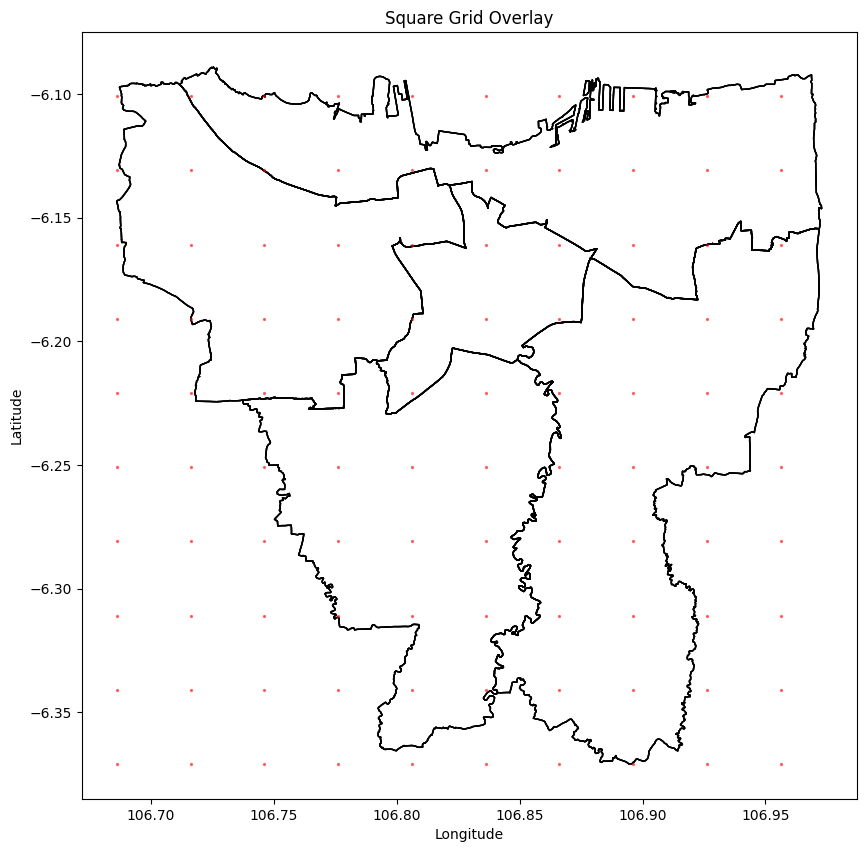

Saving plot as grid_overlay jakarta.png...


In [ ]:
#try plotting to see how
plot_grid(df, grid_pts, file_name="grid_overlay jakarta.png")

In [ ]:
# Compute points within regions of both jakarta and java
pol_pts_jkt, pt_which_pol_jkt = get_points_in_region(df, grid_pts)

Regions without points: []
✅ At least one point falls in every region!


In [ ]:
#save parameters
np.save("lat_lon_x_jkt", x)
np.save("pol_pts_jkt", pol_pts_jkt)
np.save("pt_which_pol_jkt",pt_which_pol_jkt)

In [ ]:
#check the shape
print(x.shape)
print(pol_pts_jkt.shape)
print(pt_which_pol_jkt.shape)

(100, 2)
(20, 100)
(100,)


In [ ]:
#print the shape of hdi and districts
print(df.shape)
print(df["HDI"].shape)
print(df["Pop_den"].shape)

(20, 10)
(20,)
(20,)
